In [1]:
import os
os.chdir('../')

In [48]:
   pd.set_option('display.max_columns', None)

In [6]:
from source.lib.helpers import *
import pandas as pd
import re
import warnings
import numpy as np
import matplotlib.pyplot as plt


In [7]:
warnings.filterwarnings("ignore")

In [9]:
def ProcessEventStudyPanel(df):
    df = pd.read_parquet('issue/event_study_panel.parquet')
    df_departure_date = df.query('treated == 1')[['repo_name','treatment_period','departed_actor_id']].drop_duplicates()

    # ultimately repo_list should be made all repos
    repo_list = df[df['treated']]['repo_name'].unique().tolist()
    repo_filter = [("repo_name", "in", repo_list)]
    return df_departure_date, repo_list, repo_filter

In [10]:
def CreateProblemMaps(df_problems):
    issue_problem_map = df_problems.explode('issues')[['repo_name','problem_id','issues']].dropna()
    pr_problem_map = df_problems.explode('prs')[['repo_name','problem_id','prs']].dropna()
    return issue_problem_map, pr_problem_map

In [11]:
def ExtractImportantActors(df_contributor_characteristics):
    df_contributor_characteristics['actor_id'] = pd.to_numeric(df_contributor_characteristics['actor_id'])
    df_important_actors = (
        df_contributor_characteristics
        .loc[df_contributor_characteristics['important'] == 1]
        .groupby(['repo_name', 'time_period'])['actor_id']
        .agg(RemoveDuplicatesFlattened)
        .reset_index(name='important_actors')
    )
    df_important_actors = (
        df_important_actors
        .groupby('repo_name', group_keys=False)
        .apply(lambda g: g.sort_values('time_period').assign(
            important_actors_rolling=[
                RemoveDuplicatesFlattened(
                    g['important_actors']
                     .iloc[max(0, i - rolling_periods + 1): i + 1]
                     .tolist()
                )
                for i in range(len(g))
            ]
        ))
    )
    return df_important_actors


In [15]:
def CreateBotList(df_issue_raw, df_pr_raw):
    bots = df_issue_raw.query('actor_type == "Bot"')['actor_id'].unique().tolist()
    bots = bots + df_pr_raw.query('pr_merged_by_type == "Bot"')['pr_merged_by_id'].unique().tolist()
    return bots

In [16]:
def SeparatePRsIssues(df_pr_raw, df_issue_raw, time_period):
    pr_index = df_pr_raw[['repo_name','pr_number']].drop_duplicates().set_index(['repo_name','pr_number']).index
    df_issue = df_issue_raw.loc[~df_issue_raw.set_index(['repo_name','issue_number']).index.isin(pr_index)]
    df_issue = ImputeTimePeriod(df_issue, time_period)
    
    df_pr = ImputeTimePeriod(df_pr_raw, time_period)
    df_pr_comments = df_issue_raw.loc[df_issue_raw.set_index(['repo_name','issue_number']).index.isin(pr_index)]
    df_pr_comments = ImputeTimePeriod(df_pr_comments, time_period)

    return df_issue, df_pr, df_pr_comments

In [21]:
def CreateDiscussion(df_issue, problem_map, map_merge_col, bots):
    df = df_issue.query('issue_action != "closed" & actor_id not in @bots').copy()
    df = pd.merge(df, problem_map, how='left', left_on=['repo_name', 'issue_number'], right_on = ['repo_name',map_merge_col])
    assert df['problem_id'].isna().mean() < 0.01
    df = df[df['problem_id'].notna()]

    df['body'] = df['issue_body'].fillna('') + df['issue_comment_body'].fillna('')
    df = AddBodyMetrics(df)
    return df
    
def AddBodyMetrics(df):
    """
    Given a DataFrame with a 'body' column, add the following columns:
      - cleaned_body: text after applying CleanText
      - body_len: character length of 'body'
      - cleaned_body_len: character length of 'cleaned_body'
      - body_wd_len: word count of 'body'
      - cleaned_body_wd_len: word count of 'cleaned_body'
    """
    df['cleaned_body'] = df['body'].apply(CleanText)
    df['body_len'] = df['body'].str.len()
    df['cleaned_body_len'] = df['cleaned_body'].str.len()
    df['body_wd_len'] = df['body'].str.split().str.len()
    df['cleaned_body_wd_len'] = df['cleaned_body'].str.split().str.len()
    
    return df

def CleanText(text):
    fenced_code_block_pattern = re.compile(r'```[\s\S]*?```')
    if not isinstance(text, str):
        return ''
    no_code = fenced_code_block_pattern.sub('', text)
    cleaned = re.sub(r'[\r\n\t\f\v]', ' ', no_code)
    return cleaned.strip()
 

def GetUniqueContributors(df_issue_disc, actor_type):
    df_grouped = df_issue_disc.groupby(['repo_name', 'problem_id', 'time_period'])['actor_id'].agg(
        RemoveDuplicatesFlattened).reset_index().rename(columns={'actor_id':f'{actor_type}_actors'})
    return df_grouped

def GetContributorWeights(df_issue_disc, actor_type):
    df = df_issue_disc.groupby(['repo_name', 'problem_id', 'time_period', 'actor_id']).agg(
        contributions=('body', 'count'),
        contributions_text_wt=('body_len', 'sum'),
        contributions_clean_text_wt=('cleaned_body_len', 'sum'),
        contributions_text_wd_wt=('body_wd_len', 'sum'),
        contributions_clean_text_wd_wt=('cleaned_body_wd_len', 'sum')).reset_index()

    df_grouped = df.groupby(['repo_name', 'problem_id', 'time_period']).apply(
        lambda g: {
            r['actor_id']: {
                'contributions': r['contributions'],
                'contributions_text_wt': r['contributions_text_wt'],
                'contributions_clean_text_wt': r['contributions_clean_text_wt'],
                'contributions_text_wd_wt': r['contributions_text_wd_wt'],
                'contributions_clean_text_wd_wt': r['contributions_clean_text_wd_wt']
            } for _, r in g.iterrows()
        }
    ).reset_index(name=f'{actor_type}_contributions_dict')
    return df_grouped

In [25]:
def FilterPRComments(df_pr, df_pr_comments):
    opened_prs = df_pr.loc[df_pr['pr_action'] == 'opened', ['repo_name', 'pr_number']]
    opened_keys = set(zip(opened_prs['repo_name'], opened_prs['pr_number']))
    
    df_pr_comments['_key'] = list(zip(df_pr_comments['repo_name'], df_pr_comments['issue_number']))
    mask = (df_pr_comments['issue_action'] == 'opened') & df_pr_comments['_key'].isin(opened_keys)
    df_pr_comments = df_pr_comments.loc[~mask].drop(columns='_key')
    return df_pr_comments

def CreatePRDiscussion(df_pr, pr_problem_map, bots):
    df = df_pr.query('actor_id not in @bots').copy()
    df = df.merge(pr_problem_map, how='left', left_on=['repo_name', 'pr_number'], right_on=['repo_name', 'prs'])
    assert df['problem_id'].notna().mean() > 0.99
    df = df[df['problem_id'].notna()]
    
    df['pr_body'] = df['pr_body'].fillna(df.groupby('pr_number')['pr_body'].transform('first'))
    df['pr_title'] = df['pr_title'].fillna(df.groupby('pr_number')['pr_title'].transform('first'))
    df = df.query('pr_action not in ["closed","reopened","synchronize"]').copy()
    
    def ComputePRBody(row):
        if row['type'] == "PullRequestEvent":
            return row['pr_body'] or ""
        if row['type'] == "PullRequestReviewEvent":
            return row['pr_review_body'] or ""
        return row['pr_review_comment_body'] or ""
    
    df['body'] = df.apply(ComputePRBody, axis=1)
    df = AddBodyMetrics(df)
    return df


In [33]:
def CombineContributionDicts(issue, pr):
    if not isinstance(issue, dict) and not isinstance(pr, dict):
        return np.nan
    i, p = (issue if isinstance(issue, dict) else {}), (pr if isinstance(pr, dict) else {})
    return {
        k: CombineContributionDicts(i.get(k, {}), p.get(k, {}))
            if isinstance(i.get(k), dict) or isinstance(p.get(k), dict)
        else ( (i.get(k) if isinstance(i.get(k), (int, float)) else 0)
               + (p.get(k) if isinstance(p.get(k), (int, float)) else 0) )
        for k in set(i) | set(p)
    }
    

In [34]:
def IndicatorCollaboration(df, imp_actor_col, collab_col):
    df[collab_col] = [
        int(len(set(all_acts) & set(imp_acts)) >= 2)
        for all_acts, imp_acts in zip(df['all_actors'], df[imp_actor_col])
    ]
    return df

def KeyIndicatorCollaboration(df, imp_actor_col, collab_col):
    df[collab_col] = [
        int(len(set(all_acts) & set(imp_acts)) >= 2) if dep_act in all_acts else np.nan
        for all_acts, imp_acts, dep_act in zip(df['all_actors'], df[imp_actor_col], df['departed_actor_id'])
    ]
    return df

def OtherIndicatorCollaboration(df, imp_actor_col, collab_col):
    df[collab_col] = [
        int(len(set(all_acts) & set(imp_acts)) >= 2) if dep_act not in all_acts else np.nan
        for all_acts, imp_acts, dep_act in zip(df['all_actors'], df[imp_actor_col], df['departed_actor_id'])
    ]
    return df

def ContinuousCollaboration(df, imp_actor_col, contr_col, collab_col):
    def compute_collab(row):
        contr_dict = row['contributions_dict']
        imp_acts = set(row[imp_actor_col])
        common = imp_acts & set(contr_dict.keys())
        if len(common) < 2:
            return 0
        values = [contr_dict[actor].get(contr_col, 0) for actor in common]
        top_two = sorted(values, reverse=True)[:2]
        total = sum(top_two)
        if total == 0:
            return 0
        top_two_shares = [v / total for v in top_two]
        # Compute ((v1^2 + v2^2) / (2 * 1/4))
        return 2 * sum(v**2 for v in top_two_shares)
    
    df[collab_col] = df.apply(compute_collab, axis=1)
    return df


In [166]:

def WeightedMean(values, weights):
    return (values * weights).sum() / weights.sum()


In [12]:
#def Main():

time_period = 6
rolling_periods = 3
df_problems = pd.read_parquet('issue/matched_problems_strict.parquet')
#df_problems = pd.read_parquet('issue/matched_problems_both.parquet')
#df_problems = pd.read_parquet('issue/matched_problems_single.parquet')
df_contributor_characteristics = pd.read_parquet('drive/output/derived/graph_structure/contributor_characteristics.parquet')
issue_problem_map, pr_problem_map = CreateProblemMaps(df_problems)
df_important_actors = ExtractImportantActors(df_contributor_characteristics)
df_departure_date, repo_list, repo_filter = ProcessEventStudyPanel(df_problems)

df_issue_raw = pd.read_parquet('drive/output/derived/data_export/df_issue.parquet', filters=repo_filter)
df_pr_raw = pd.read_parquet('drive/output/derived/data_export/df_pr.parquet', filters=repo_filter)
df_pr_commits = pd.read_parquet('drive/output/derived/data_export/df_pr_commits.parquet', filters=repo_filter)

bots = CreateBotList(df_issue_raw, df_pr_raw)
df_issue, df_pr, df_pr_comments = SeparatePRsIssues(df_pr_raw, df_issue_raw, time_period)


df_issue_disc = CreateDiscussion(df_issue, issue_problem_map, 'issues', bots)
df_issue_disc_contr = GetUniqueContributors(df_issue_disc,'issue')
df_issue_disc_contr_wt = GetContributorWeights(df_issue_disc,'issue')

In [24]:

df_issue_disc = CreateDiscussion(df_issue, issue_problem_map, 'issues', bots)
df_issue_disc_contr = GetUniqueContributors(df_issue_disc,'issue')
df_issue_disc_contr_wt = GetContributorWeights(df_issue_disc,'issue')

In [26]:
df_pr_comments = FilterPRComments(df_pr, df_pr_comments)
df_pr_disc = CreatePRDiscussion(df_pr, pr_problem_map, bots)
df_pr_comments_disc = CreateDiscussion(df_pr_comments, pr_problem_map, 'prs', bots)

sel_cols = ['repo_name','problem_id','time_period','actor_id','body','cleaned_body','body_len','cleaned_body_len','body_wd_len','cleaned_body_wd_len']
df_pr_full_disc = pd.concat([df_pr_disc[sel_cols], df_pr_comments_disc[sel_cols]], ignore_index=True)
df_pr_disc_contr = GetUniqueContributors(df_pr_full_disc, 'pr')
df_pr_disc_contr_wt = GetContributorWeights(df_pr_full_disc, 'pr')

In [128]:
df_all_disc_contr = pd.merge(df_pr_disc_contr.merge(df_pr_disc_contr_wt), df_issue_disc_contr.merge(df_issue_disc_contr_wt), how = 'outer')
df_problems_contr = pd.merge(df_problems, df_all_disc_contr).merge(df_important_actors).merge(df_departure_date)

df_problems_contr['important_actors'] = df_problems_contr.apply(lambda x: list(set(x['important_actors'] + [x['departed_actor_id']])), axis = 1)
df_problems_contr['issue_actors'] = df_problems_contr['issue_actors'].apply(lambda x: x if isinstance(x, list) else [])
df_problems_contr['pr_actors'] = df_problems_contr['pr_actors'].apply(lambda x: x if isinstance(x, list) else [])
df_problems_contr['all_actors'] = [list(dict.fromkeys(issue + pr)) for issue, pr in zip(df_problems_contr['issue_actors'], df_problems_contr['pr_actors'])]
df_problems_contr['problem_contr_count'] = df_problems_contr['all_actors'].apply(len)
df_problems_contr['contributions_dict'] = df_problems_contr.apply(lambda x: CombineContributionDicts(x['issue_contributions_dict'], x['pr_contributions_dict']), axis = 1)
df_problems_contr['total_prob_contr'] = df_problems_contr['contributions_dict'].apply(lambda d: sum(v.get('contributions', 0) for v in d.values()))

df_all_actors_period = df_problems_contr.groupby(['repo_name','time_period'])['all_actors'].agg(RemoveDuplicatesFlattened).reset_index(name = 'all_actors_period')
df_problems_contr = pd.merge(df_problems_contr, df_all_actors_period)
df_problems_contr['important_actors_rolling'] = df_problems_contr.apply(lambda x: list(set(x['important_actors_rolling'] + [x['departed_actor_id']])), axis = 1)
df_problems_contr['important_actors_rolling'] = df_problems_contr.apply(lambda x: [ele for ele in x['important_actors_rolling'] if ele in x['all_actors_period']], axis = 1)

In [129]:
df_problems_contr = IndicatorCollaboration(df_problems_contr, 'important_actors', 'ind_collab')
df_problems_contr = IndicatorCollaboration(df_problems_contr, 'important_actors_rolling', 'ind_collab_roll')
df_problems_contr = KeyIndicatorCollaboration(df_problems_contr, 'important_actors_rolling', 'ind_key_collab_roll')
df_problems_contr = OtherIndicatorCollaboration(df_problems_contr, 'important_actors_rolling', 'ind_other_collab_roll')
df_problems_contr = ContinuousCollaboration(df_problems_contr, 'important_actors_rolling', 'contributions', 'cont_collab_roll')
df_problems_contr = ContinuousCollaboration(df_problems_contr, 'important_actors_rolling', 'contributions_clean_text_wt', 'cont_collab_clean_char_roll')
df_problems_contr = ContinuousCollaboration(df_problems_contr, 'important_actors_rolling', 'contributions_clean_text_wd_wt', 'cont_collab_clean_wd_roll')

In [141]:
df_problems_contr_pre_period = df_problems_contr.query('time_period<treatment_period')
# Identify repo_names where every row has at least 2 important_actors
repo_valid = (
    df_problems_contr.query('time_period<treatment_period')
    .groupby('repo_name')['important_actors_rolling']
    .apply(lambda s: s.str.len().min() >= 2)
)

# Filter to keep only those repo_names
valid_repos = repo_valid[repo_valid].index
df_problems_contr_filtered = df_problems_contr[df_problems_contr['repo_name'].isin(valid_repos)]
df_problems_contr_filtered_pre_period = df_problems_contr_filtered.query('time_period<treatment_period')
print(f"{len(valid_repos)} projects have at least 2 important contributors (rolling) always in the pre-period, out of a total of {len(repo_valid)} projects")
print(f"They represents {df_problems_contr_filtered_pre_period.shape[0]} out of {df_problems_contr_pre_period.shape[0]} problems in the pre period \
({df_problems_contr_filtered_pre_period.shape[0]/df_problems_contr_pre_period.shape[0]:.2f})")

95 projects have at least 2 important contributors (rolling) always in the pre-period, out of a total of 262 projects
They represents 168459 out of 265128 problems in the pre period (0.64)


In [142]:
import json

for col in ['pr_contributions_dict','issue_contributions_dict','contributions_dict']:
    # ensure every entry is at least {} and then dump to JSON
    df_problems_contr_filtered[col] = (
        df_problems_contr_filtered[col]
        .apply(lambda x: x if isinstance(x, dict) else {})
        .apply(json.dumps)
    )

# now this will work
df_problems_contr_filtered.to_parquet('issue/filtered_problem_data.parquet', index=False)


In [177]:
# controls that I can add down the road
# % of problems that are unlinked prs/linked
# 
df_problems_contr_filtered['departed_involved'] = df_problems_contr_filtered.apply(lambda x: x['departed_actor_id'] in x['all_actors'], axis = 1)
df_project_filtered_group = df_problems_contr_filtered.groupby(
    ['repo_name', 'time_period', 'treatment_period']
).agg(
    problem_count=('problem_id', 'count'),
    ind_collab=('ind_collab_roll', 'mean'),
    ind_key_collab=('ind_key_collab_roll', 'mean'),
    ind_other_collab=('ind_other_collab_roll', 'mean'),
    departed_involved_count=('departed_involved','sum'),
    departed_involved=('departed_involved','mean')
).reset_index()


In [179]:
def WeightedQuantile(values, weights, quantiles):
    values = np.array(values)
    weights = np.array(weights)
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    cumulative_weight = np.cumsum(weights)
    total_weight = cumulative_weight[-1]
    return np.interp(np.array(quantiles) * total_weight, cumulative_weight, values)

def Assign3Bin(repo):
    val = base_wm[repo]
    if val <= q33:
        return 0
    elif val <= q67:
        return 1
    else:
        return 2

preperiod_recent = df_project_filtered_group.query('time_period < treatment_period').groupby('repo_name').tail(5)
preperiod_recent['other_involved_count'] = preperiod_recent['departed_involved_count'] - preperiod_recent['problem_count']

count_dict = {
    'ind_collab': 'problem_count',
    'ind_key_collab': 'departed_involved_count',
    'ind_other_collab': 'other_involved_count'
}

for collab_type in ['ind_collab', 'ind_key_collab', 'ind_other_collab']:
    count_col = count_dict[collab_type]
    avg_collab = WeightedMean(preperiod_recent[collab_type], preperiod_recent[count_col])
    base_wm = preperiod_recent.groupby('repo_name').apply(
        lambda df: WeightedMean(df[collab_type], df[count_col])
    )

    above_set = set(base_wm[base_wm > avg_collab].index)
    df_project_filtered_group[f"{collab_type}_2bin"] = df_project_filtered_group['repo_name'].apply(lambda x: int(x in above_set))

    # 3-bin: weighted quantiles
    q33, q67 = WeightedQuantile(preperiod_recent[collab_type], preperiod_recent[count_col], [0.33, 0.67])

    df_project_filtered_group[f"{collab_type}_3bin"] = df_project_filtered_group['repo_name'].apply(Assign3Bin)

df_project_filtered_group.to_parquet('issue/project_collaboration.parquet')

In [72]:
"""
SummarizeAndPlotCollaboration(df_problems_contr_pre_period, last_n=5)
print("Distribution of problem count in all project-time periods pre-departure")
print(pd.DataFrame(df_problems_contr_pre_period[['repo_name','time_period']].value_counts().describe()).T.round(2))
print("Distribution of avg. # of contributors per problem  in all project-time periods pre-departure")
print(pd.DataFrame(df_problems_contr_pre_period.groupby(['repo_name','time_period'])['problem_contr_count'].mean().describe()).T.round(2))
"""

'\nSummarizeAndPlotCollaboration(df_problems_contr_pre_period, last_n=5)\nprint("Distribution of problem count in all project-time periods pre-departure")\nprint(pd.DataFrame(df_problems_contr_pre_period[[\'repo_name\',\'time_period\']].value_counts().describe()).T.round(2))\nprint("Distribution of avg. # of contributors per problem  in all project-time periods pre-departure")\nprint(pd.DataFrame(df_problems_contr_pre_period.groupby([\'repo_name\',\'time_period\'])[\'problem_contr_count\'].mean().describe()).T.round(2))\n'

# BELOW IS ANALYSIS, move into separate script

In [144]:
corr = df_problems_contr_filtered_pre_period[['ind_collab', 'cont_collab_roll']].corr().iloc[0, 1]
corr_word = df_problems_contr_filtered_pre_period[['ind_collab', 'cont_collab_clean_wd_roll']].corr().iloc[0, 1]
corr_char = df_problems_contr_filtered_pre_period[['ind_collab', 'cont_collab_clean_char_roll']].corr().iloc[0, 1]
print(f"At the problem level, the correlation between the indicator and continuous collaboration metric is {corr:.2f}")
print(f"At the problem level, the correlation between the indicator and continuous collaboration metric (using words as shares) is {corr_word:.2f}")
print(f"At the problem level, the correlation between the indicator and continuous collaboration metric (using characters as shares) is {corr_char:.2f}")

At the problem level, the correlation between the indicator and continuous collaboration metric is 0.94
At the problem level, the correlation between the indicator and continuous collaboration metric (using words as shares) is 0.92
At the problem level, the correlation between the indicator and continuous collaboration metric (using characters as shares) is 0.92


In [145]:
def PrintMetricSummary(time_series, recent_series, metric_name, last_n):
    print(f"Distribution of {metric_name} per project-period, pre-departure")
    print(time_series.describe().to_frame().T.round(2))
    print(f"Std dev across all project-periods: {time_series.std():.2f}")
    print(f"Std dev across most recent {last_n} periods: {recent_series.std():.2f}")
    print(f"Std dev across projects (avg over last {last_n} periods): {recent_series.groupby('repo_name').mean().std():.2f}")

def SummarizeAndPlotCollaboration(df_problems, metric_col, display_name, last_n, ax, weight_col=None):
    df = df_problems.copy()
    df[display_name] = df[metric_col]

    def compute_time_series():
        if weight_col:
            return df.groupby(['repo_name', 'time_period']).apply(lambda g: (g[display_name] * g[weight_col]).sum() / g[weight_col].sum())
        return df.groupby(['repo_name', 'time_period'])[display_name].mean()

    ts = compute_time_series().rename(display_name)
    recent = ts.groupby(level='repo_name').tail(last_n)
    avg_recent = recent.groupby(level='repo_name').mean()

    PrintMetricSummary(ts, recent, display_name, last_n)

    all_vals = ts.values
    recent_vals = recent.values
    avg_vals = avg_recent.values
    combined = np.concatenate([all_vals, recent_vals, avg_vals])
    combined = combined[~np.isnan(combined)]
    if combined.size:
        bins = np.linspace(combined.min(), combined.max(), 41)
        def plot_bar(vals, label):
            weights = np.ones_like(vals) / len(vals)
            ax.hist(vals, bins=bins, weights=weights, alpha=0.5,
                    edgecolor='black', label=label)
        if all_vals.size:
            plot_bar(all_vals, 'All project-periods')
        if recent_vals.size:
            plot_bar(recent_vals, f'Last {last_n} project-periods')
        if avg_vals.size:
            plot_bar(avg_vals, f'Projects (over last {last_n} periods)')
        ax.set_xlabel(display_name)
        ax.set_ylabel('Proportion')
        ax.set_title(f'Aggregate distribution of {display_name}')
        ax.legend()

    return ts, recent

def SummarizeProblemCounts(df_problems, metrics, last_n=5, nrows=1, weight_col = None):
    n_metrics = len(metrics)
    ncols = int(np.ceil(n_metrics / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    axes = np.array(axes).reshape(-1)

    for idx, (metric_col, display_name, description) in enumerate(metrics):
        print(f"Distribution of {description} per project-period, pre departure")
        mask = df_problems[metric_col].notna()
        summary = (df_problems.loc[mask, ['repo_name', 'time_period']].value_counts().describe().to_frame().T.round(2))
        print(summary)
        SummarizeAndPlotCollaboration(df_problems, metric_col, display_name, last_n, axes[idx], weight_col)
        print("\n")
    for j in range(n_metrics, nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Distribution of problem count per project-period, pre departure
       count   mean     std  min   25%    50%     75%     max
count  656.0  256.8  326.75  3.0  56.0  130.5  321.25  2824.0
Distribution of Ov. Indicator Collaboration per project-period, pre-departure
                             count  mean   std  min   25%   50%   75%   max
Ov. Indicator Collaboration  656.0  0.26  0.18  0.0  0.12  0.24  0.38  0.92
Std dev across all project-periods: 0.18
Std dev across most recent 5 periods: 0.17
Std dev across projects (avg over last 5 periods): 0.14


Distribution of problem count per project-period, pre departure
       count   mean     std  min   25%    50%     75%     max
count  656.0  256.8  326.75  3.0  56.0  130.5  321.25  2824.0
Distribution of Ov. Continuous Collaboration per project-period, pre-departure
                              count  mean   std  min   25%   50%   75%   max
Ov. Continuous Collaboration  656.0  0.29  0.19  0.0  0.13  0.27  0.41  0.98
Std dev across all 

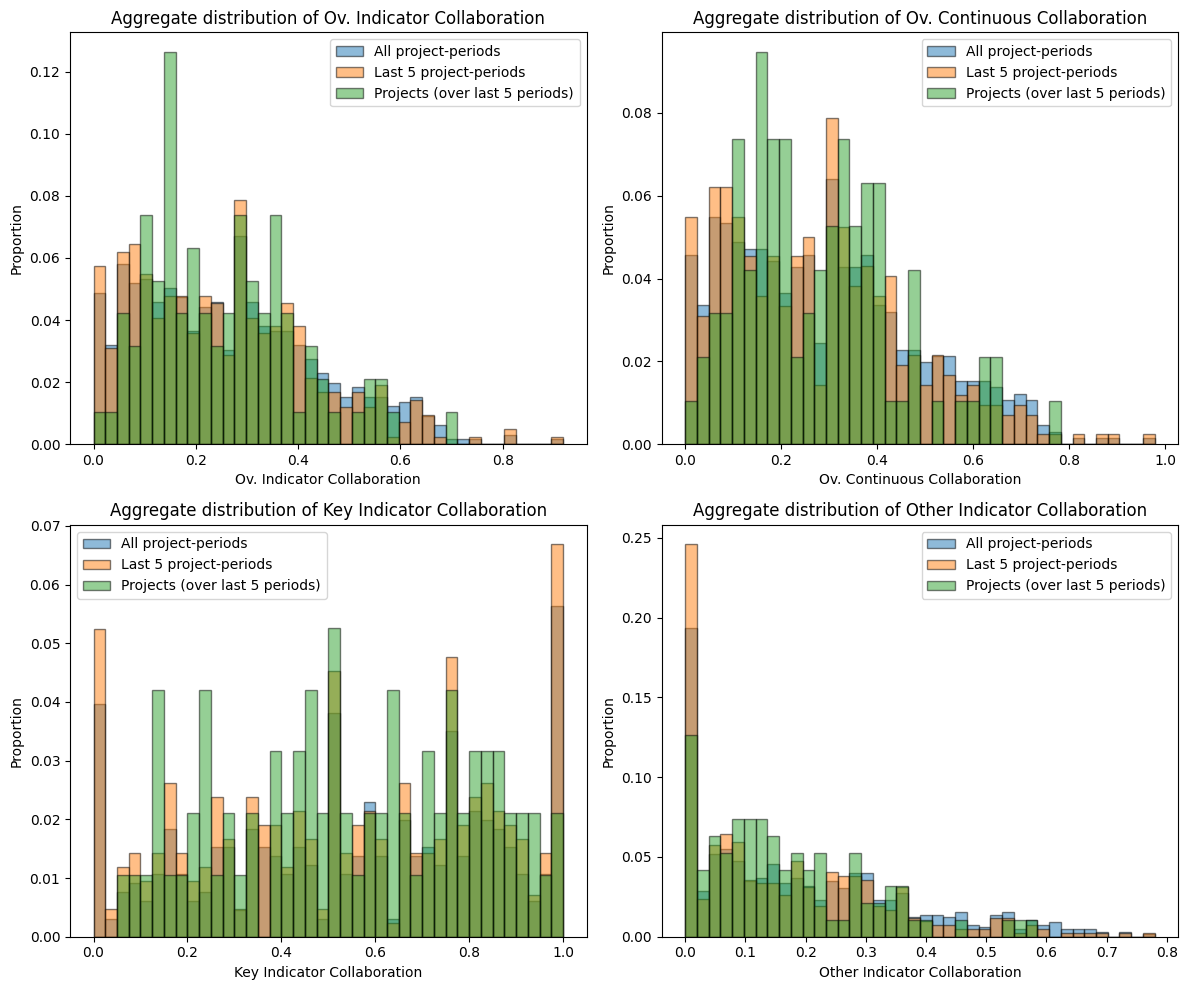

In [146]:
metrics = [
    ('ind_collab_roll',       'Ov. Indicator Collaboration',   'problem count'),
    ('cont_collab_roll',       'Ov. Continuous Collaboration',   'problem count'),
    ('ind_key_collab_roll',   'Key Indicator Collaboration',   'key problem count'),
    ('ind_other_collab_roll', 'Other Indicator Collaboration', 'other problem count'),
]

SummarizeProblemCounts(df_problems_contr_filtered_pre_period, metrics, last_n=5, nrows=2)

In [147]:
# look into why weighting makes projects less collaborative?
"""
metrics = [
    ('ind_collab_roll',       'Ov. Indicator Collaboration',   'problem count'),
    ('cont_collab_roll',       'Ov. Continuous Collaboration',   'problem count'),
    ('ind_key_collab_roll',   'Key Indicator Collaboration',   'key problem count'),
    ('ind_other_collab_roll', 'Other Indicator Collaboration', 'other problem count'),
]

SummarizeProblemCounts(df_problems_contr_filtered_pre_period, metrics, last_n=5, nrows=2, weight_col = 'total_prob_contr')
"""

"\nmetrics = [\n    ('ind_collab_roll',       'Ov. Indicator Collaboration',   'problem count'),\n    ('cont_collab_roll',       'Ov. Continuous Collaboration',   'problem count'),\n    ('ind_key_collab_roll',   'Key Indicator Collaboration',   'key problem count'),\n    ('ind_other_collab_roll', 'Other Indicator Collaboration', 'other problem count'),\n]\n\nSummarizeProblemCounts(df_problems_contr_filtered_pre_period, metrics, last_n=5, nrows=2, weight_col = 'total_prob_contr')\n"

In [148]:
df_dept_present = df_problems_contr_filtered_pre_period[df_problems_contr_filtered_pre_period.apply(
    lambda x: x['departed_actor_id'] in x['all_actors'], axis = 1)][['repo_name','time_period']].drop_duplicates()
print(pd.merge(df_dept_present, df_problems_contr_filtered_pre_period).apply(lambda x: x['departed_actor_id'] in x['all_actors'], axis = 1).mean())
print(1-df_problems_contr_filtered_pre_period['ind_key_collab_roll'].isna().mean())

0.18699841794908673
0.11577297740102932


In [149]:
import pandas as pd
import statsmodels.formula.api as smf

def run_collaboration_trend(df_problems_contr_filtered_pre_period, collab_col, last_n_periods=None, repo_fe=True, time_fe=True):
    df_summary = (
        df_problems_contr_filtered_pre_period
        .groupby(['repo_name', 'time_period'])[collab_col]
        .mean()
        .reset_index()
    )
    df_summary = df_summary[~df_summary[collab_col].isna()]

    df_summary['time_period_number'] = df_summary.groupby('repo_name')['time_period'].transform(
        lambda x: x.map({
            tp: i - (len(sorted(x.unique())) - 1)
            for i, tp in enumerate(sorted(x.unique()))
        })
    )

    if last_n_periods is not None:
        df_summary = df_summary[df_summary['time_period_number'] >= -last_n_periods].copy()

    repofe = '+ C(repo_name)' if repo_fe else ''
    timefe = '+ C(time_period)' if time_fe else ''

    model = smf.ols(
        formula=f'{collab_col} ~ time_period_number {repofe} {timefe}',
        data=df_summary
    ).fit(
        cov_type='cluster',
        cov_kwds={'groups': df_summary['repo_name']}
    )

    coef_table = model.summary2().tables[1].copy()
    coef_table = coef_table[~coef_table.index.str.startswith('C(repo_name)')]

    return coef_table

def GenerateReport(df_problems_contr, collab_col, annualize=False):
    configs = [
        {'last_n_periods': None, 'repo_fe': False, 'time_fe': False, 'period_label': 'All periods'},
        {'last_n_periods': 5, 'repo_fe': False, 'time_fe': False, 'period_label': 'Last 5 periods'},
        {'last_n_periods': None, 'repo_fe': True, 'time_fe': True, 'period_label': 'All periods (FE)'},
        {'last_n_periods': 5, 'repo_fe': True, 'time_fe': True, 'period_label': 'Last 5 periods (FE)'}
    ]
    
    results = []
    for config in configs:
        coef_table = run_collaboration_trend(
            df_problems_contr,
            collab_col=collab_col,
            last_n_periods=config['last_n_periods'],
            repo_fe=config['repo_fe'],
            time_fe=config['time_fe']
        )
        if annualize:
            coef_table.loc[['time_period_number'], 'Coef.'] *= 2
            coef_table.loc[['time_period_number'], 'Std.Err.'] *= 2

        results.append({
            'Period Range': config['period_label'],
            'Coefficient': f"{coef_table.loc[['time_period_number']]['Coef.'].values[0]:.3f}",
            'Std.Err.': f"({coef_table.loc[['time_period_number']]['Std.Err.'].values[0]:.3f})",
            'Period FE': 'Yes' if config['time_fe'] else 'No',
            'Project FE': 'Yes' if config['repo_fe'] else 'No'
        })
    
    result_df = pd.DataFrame(results)

    print(result_df.to_markdown(index=False))

for idx, (metric_col, display_name, description) in enumerate(metrics):
    print(f"Collaboration stability for {display_name}")
    print(metric_col)
    GenerateReport(df_problems_contr_filtered_pre_period, collab_col = metric_col, annualize = True)

Collaboration stability for Ov. Indicator Collaboration
ind_collab_roll


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 111, but rank is 16
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 14
  warnings.warn('covariance of constraints does not have full '


| Period Range        |   Coefficient | Std.Err.   | Period FE   | Project FE   |
|:--------------------|--------------:|:-----------|:------------|:-------------|
| All periods         |        -0.011 | (0.007)    | No          | No           |
| Last 5 periods      |         0.009 | (0.010)    | No          | No           |
| All periods (FE)    |         0.007 | (0.011)    | Yes         | Yes          |
| Last 5 periods (FE) |         0.008 | (0.009)    | Yes         | Yes          |
Collaboration stability for Ov. Continuous Collaboration
cont_collab_roll


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 111, but rank is 16
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 14
  warnings.warn('covariance of constraints does not have full '


| Period Range        |   Coefficient | Std.Err.   | Period FE   | Project FE   |
|:--------------------|--------------:|:-----------|:------------|:-------------|
| All periods         |        -0.013 | (0.007)    | No          | No           |
| Last 5 periods      |         0.01  | (0.011)    | No          | No           |
| All periods (FE)    |         0.009 | (0.012)    | Yes         | Yes          |
| Last 5 periods (FE) |         0.011 | (0.010)    | Yes         | Yes          |
Collaboration stability for Key Indicator Collaboration
ind_key_collab_roll
| Period Range        |   Coefficient | Std.Err.   | Period FE   | Project FE   |
|:--------------------|--------------:|:-----------|:------------|:-------------|
| All periods         |        -0.014 | (0.016)    | No          | No           |
| Last 5 periods      |         0.03  | (0.021)    | No          | No           |
| All periods (FE)    |        -0.005 | (0.066)    | Yes         | Yes          |
| Last 5 periods (FE) 

/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 97, but rank is 15
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 97, but rank is 15
  warnings.warn('covariance of constraints does not have full '


| Period Range        |   Coefficient | Std.Err.   | Period FE   | Project FE   |
|:--------------------|--------------:|:-----------|:------------|:-------------|
| All periods         |        -0.028 | (0.007)    | No          | No           |
| Last 5 periods      |        -0.006 | (0.010)    | No          | No           |
| All periods (FE)    |        -0.005 | (0.009)    | Yes         | Yes          |
| Last 5 periods (FE) |         0.001 | (0.012)    | Yes         | Yes          |


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 111, but rank is 16
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 110, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [150]:
def ComputeLagCorrelation(series):
    return series.corr(series.shift(1))

collab_type = 'ind_collab_roll'
for min_denom in [1,5, 10, 20, 50]:
    project_time_collab = (
        df_problems_contr_filtered_pre_period
        .groupby(['repo_name','time_period'])[collab_type]
        .agg(count='size', mean_collab='mean')
        .reset_index()
        .sort_values(['repo_name','time_period'])
    )
    project_time_collab['mean_collab'] = project_time_collab['mean_collab'].where(
        project_time_collab['count'] >= min_denom, np.nan
    )
    project_time_collab_recent = project_time_collab.groupby('repo_name').tail(5)
    
    print(f"Minimum problem count in a time period: {min_denom}")
    print("Prop. missing months: {:.2f}".format(project_time_collab['mean_collab'].isna().mean()))
    print("Prop. missing months (recent): {:.2f}".format(project_time_collab_recent['mean_collab'].isna().mean()))
    print("Across all projects, the average absolute correlation between collaboration in time t and t-1 is {:.2f}".format(
        project_time_collab.groupby('repo_name')['mean_collab'].apply(ComputeLagCorrelation).mean()))
    print("Across all projects, in the 5 periods prior to departure, the average absolute correlation between collaboration in time t and t-1 is {:.2f}\n".format(
        project_time_collab_recent.groupby('repo_name')['mean_collab'].apply(ComputeLagCorrelation).mean()))

Minimum problem count in a time period: 1
Prop. missing months: 0.00
Prop. missing months (recent): 0.00
Across all projects, the average absolute correlation between collaboration in time t and t-1 is 0.04
Across all projects, in the 5 periods prior to departure, the average absolute correlation between collaboration in time t and t-1 is -0.11

Minimum problem count in a time period: 5
Prop. missing months: 0.00
Prop. missing months (recent): 0.00
Across all projects, the average absolute correlation between collaboration in time t and t-1 is 0.05
Across all projects, in the 5 periods prior to departure, the average absolute correlation between collaboration in time t and t-1 is -0.10

Minimum problem count in a time period: 10
Prop. missing months: 0.02
Prop. missing months (recent): 0.02
Across all projects, the average absolute correlation between collaboration in time t and t-1 is 0.01
Across all projects, in the 5 periods prior to departure, the average absolute correlation betwe

In [151]:

def CompareAboveBelowCollab(collab_type = 'ind_collab_roll', min_denom   = 5):
    
    ptc = (
        df_problems_contr_filtered_pre_period
        .groupby(['repo_name','time_period'])[collab_type]
        .agg(count='size', mean_collab='mean')
        .reset_index()
        .sort_values(['repo_name','time_period'])
    )
    
    rows = []
    for baseline in (1, 2, 3, 4):
        # — baseline window
        base_df = ptc.groupby('repo_name').tail(baseline)
        valid_baseline = base_df.groupby('repo_name')['count'].sum().ge(min_denom)
        base_df = base_df[base_df['repo_name'].isin(valid_baseline[valid_baseline].index)]
        avg_collab = WeightedMean(base_df['mean_collab'], base_df['count'])
        base_wm = base_df.groupby('repo_name') \
                         .apply(lambda df: WeightedMean(df['mean_collab'], df['count']))
        above_set = set(base_wm[base_wm > avg_collab].index)
        below_set = set(base_wm[base_wm <= avg_collab].index)
        above_n, below_n = len(above_set), len(below_set)
    
        for periods in range(baseline + 1, 6):
            # — periods window
            recent_df = ptc.groupby('repo_name').tail(periods)
            valid_periods = recent_df.groupby('repo_name')['count'].sum().ge(min_denom)
            recent_df = recent_df[recent_df['repo_name'].isin(valid_periods[valid_periods].index)]
    
            recent_wm = recent_df.groupby('repo_name') \
                                 .apply(lambda df: WeightedMean(df['mean_collab'], df['count']))
    
            kept_above = len(above_set & set(recent_wm[recent_wm > avg_collab].index))
            kept_below = len(below_set & set(recent_wm[recent_wm <= avg_collab].index))
    
            rows.append({
                'baseline': baseline,
                'periods': periods,
                'above_retention': kept_above / (above_n or 1),
                'below_retention': kept_below / (below_n or 1),
                'combined_retention': (kept_above + kept_below) / ((above_n + below_n) or 1)
            })
    
    retention_df = pd.DataFrame(rows)
    print(retention_df.to_string(index=False))

CompareAboveBelowCollab(collab_type = 'ind_collab_roll', min_denom   = 5)
CompareAboveBelowCollab(collab_type = 'ind_key_collab_roll', min_denom   = 5)

 baseline  periods  above_retention  below_retention  combined_retention
        1        2         0.916667         0.915254            0.915789
        1        3         0.888889         0.847458            0.863158
        1        4         0.861111         0.830508            0.842105
        1        5         0.888889         0.830508            0.852632
        2        3         0.944444         0.898305            0.915789
        2        4         0.888889         0.864407            0.873684
        2        5         0.916667         0.847458            0.873684
        3        4         0.950000         0.963636            0.957895
        3        5         0.975000         0.945455            0.957895
        4        5         1.000000         0.963636            0.978947
 baseline  periods  above_retention  below_retention  combined_retention
        1        2         0.860465         1.000000            0.936842
        1        3         0.767442         1.00000

# this is for overall collaboration. it's also true for key collaboration
Goal: can I learn something about how collaborative projects are through my collaboration metric?
1. There's some weak evidence that collaboration is trending downwards over time. I say weak because it's statistically insignificant
2. Across projects, the average correlation between current and lagged collaboration is between -0.1 and 0.2, which also suggests that there isn't a persistent upwards/downwards trend in collaboration over time
3. The good thing is that it looks like collaboration is reasonably stable over time. I know this because if I use 1, 2, 3, 4, 5 past time periods to bin projects into above/below average collaboration, the overlap between the new and old bins is always over 85% and frequently exceeds 90% (depending on the comparison made)


In [152]:
df_dept_present = df_problems_contr_filtered_pre_period[df_problems_contr_filtered_pre_period.apply(
    lambda x: x['departed_actor_id'] in x['all_actors'], axis = 1)][['repo_name','time_period']].drop_duplicates()
print(pd.merge(df_dept_present, df_problems_contr_filtered_pre_period).apply(lambda x: x['departed_actor_id'] in x['all_actors'], axis = 1).mean())
print(1-df_problems_contr_filtered_pre_period['ind_key_collab_roll'].isna().mean())

0.18699841794908673
0.11577297740102932
